# Franceschin CERIC beamtime @ SYRMEP Elettra
## Image processing of corroded pit

Sample: 581681_patina/581681_punta_HR_stitch2

Created on:  22.04.2022 <br />
Last update: 22.04.2022 <br />

In [3]:
%%html
<style> table {float:left} </style>

|Scan parameters|   |
|:-|:-|
|Beamline|SYRMEP@Elettra|
|Sample|581681_patina/581681_punta_HR_stitch2 |
|Energy| 27 keV |
|Camera| ORCA flash |
|Voxel size| 1.0 um |
|SDD | 150 mm |
|Preliminary operations|stitch of 4 scans (normalized; 2D rigid transform) |

## Configuration

In [1]:
import sys
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

In [2]:
# import os
import numpy as np
# import dxchange
import matplotlib
import matplotlib.pyplot as plt
# import logging
# logging.basicConfig(level=logging.INFO)

# import mcubes
from scipy import ndimage, misc
# from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
from pybonemorph import remove_unconnected, remove_largest

astropy module not found
olefile module not found


In [3]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

#### Load input data
loading small portion (100 slices) of the full dataset..

In [4]:
input_file = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/slices/slice_0000.tif'

In [5]:
data_3D = read_tiff_stack(input_file, [2420, 2470])

In [ ]:
vs = np.ones(3)*1.0e-3 # [mm]

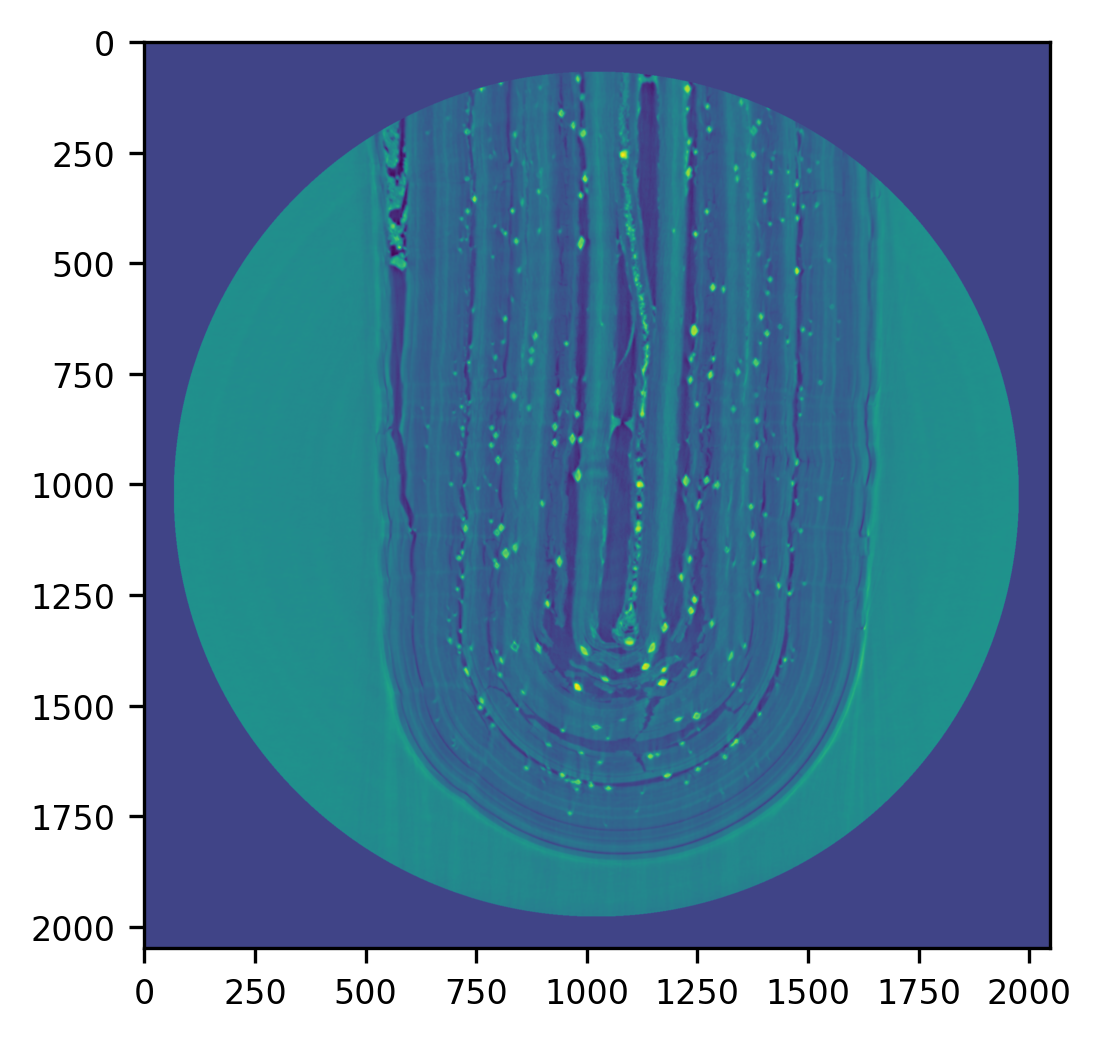

In [7]:
# Inspect slice
plt.imshow(data_3D[20,:,:])

## 1. Pre-processing
### 1.1. Gaussian smooth (don't)

In [8]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### 1.2. Resize (optional)

In [48]:
resampling = 1.2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

In [ ]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

## 2. Sample boundary mask


### 2.0. circle mask

In [6]:
BW_circle = data_3D == 0

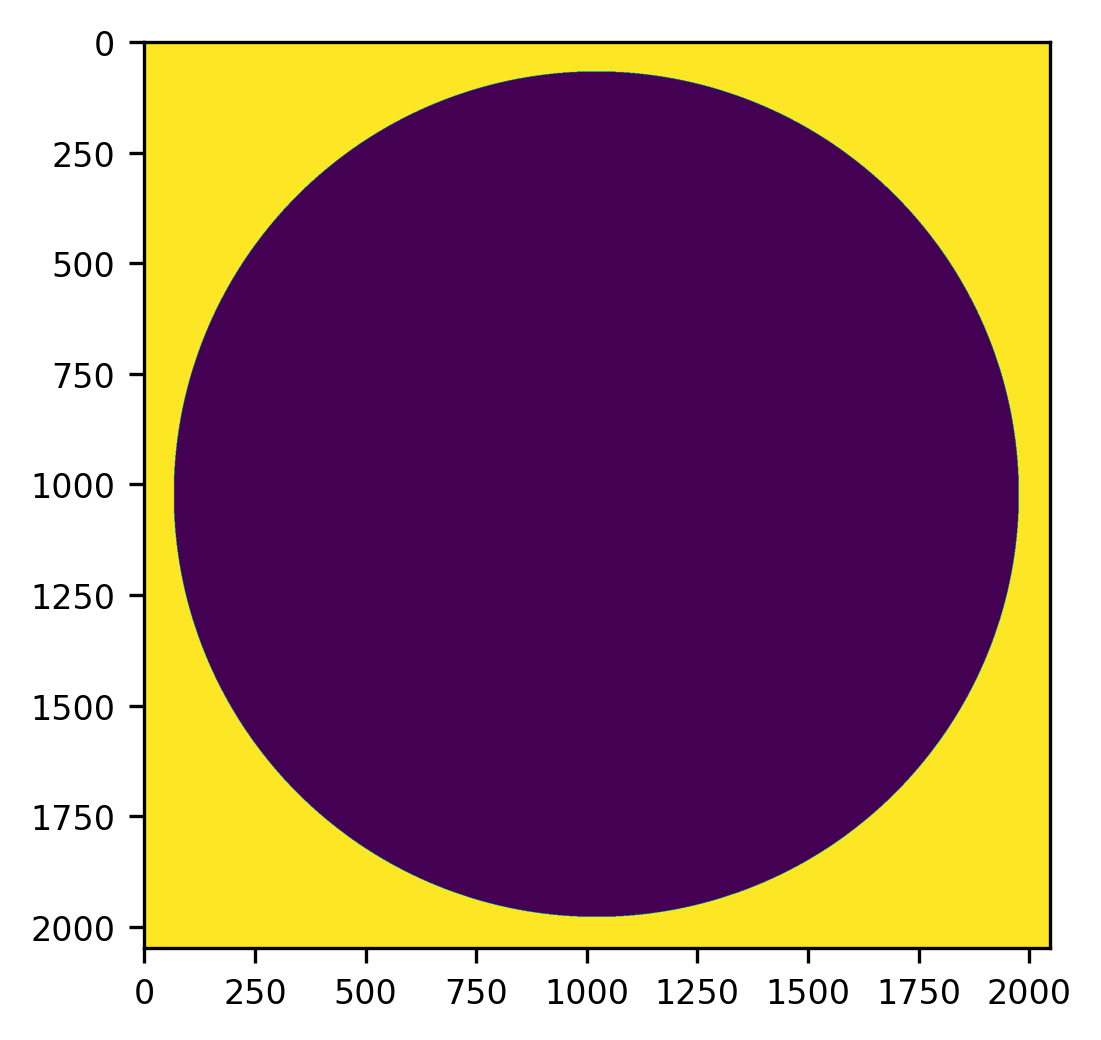

In [7]:
plt.imshow(BW_circle[20,:,:])

### 2.1. pit mask
2.1.1. Filter based on GV

In [179]:
BW_pit = (data_3D>0.000264) & (data_3D<0.00159)

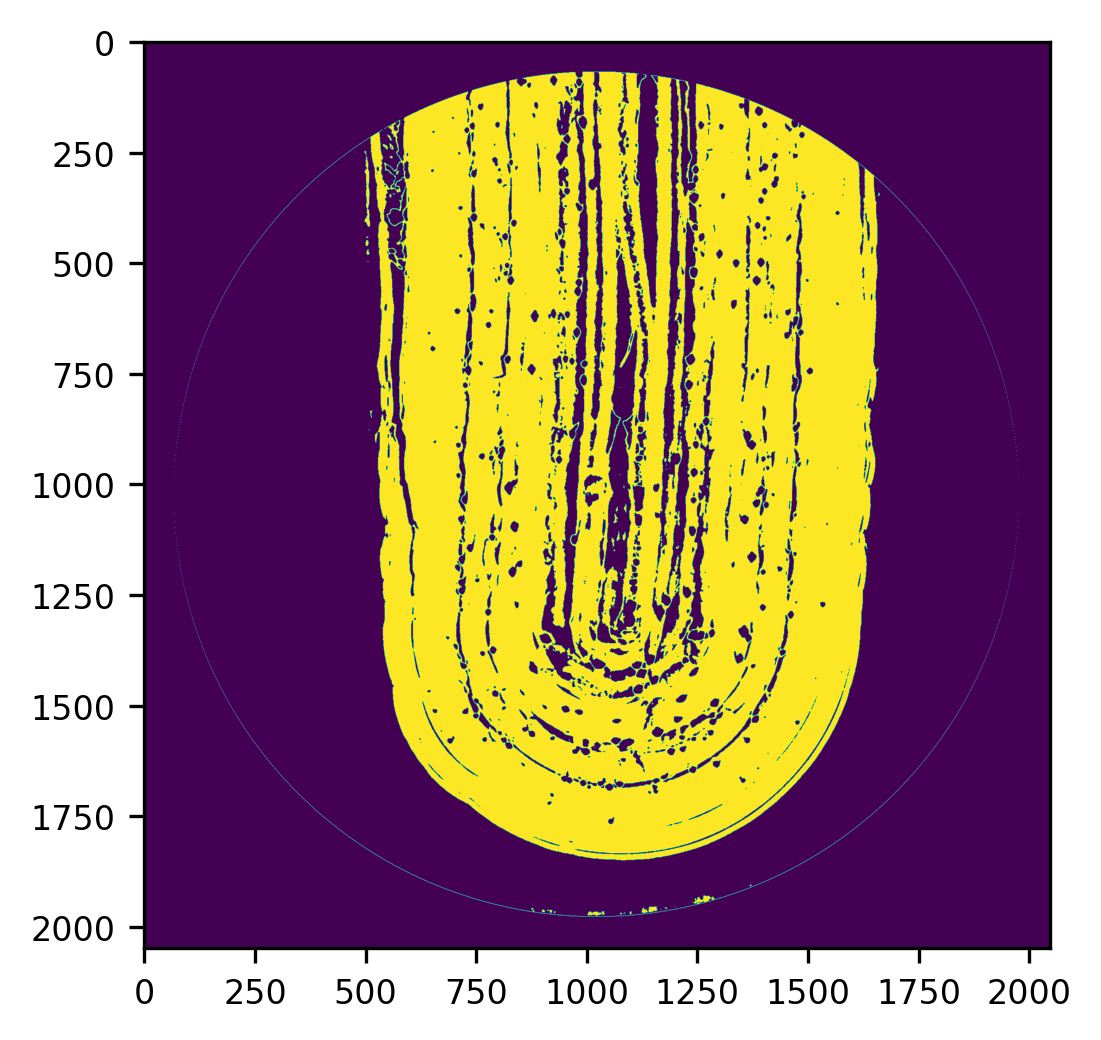

In [166]:
plt.imshow(BW_pit[0,:,:])

2.1.2. Image open to remove circle

In [9]:
# BW_pit = morphology.binary_opening(BW_pit, morphology.cube(2))

2.1.3. Fill holes within pit

In [13]:
# BW_pit = ndimage.binary_fill_holes(BW_pit)

2.1.4. Remove unconnected struts

In [180]:
BW_pit = remove_unconnected(BW_pit)

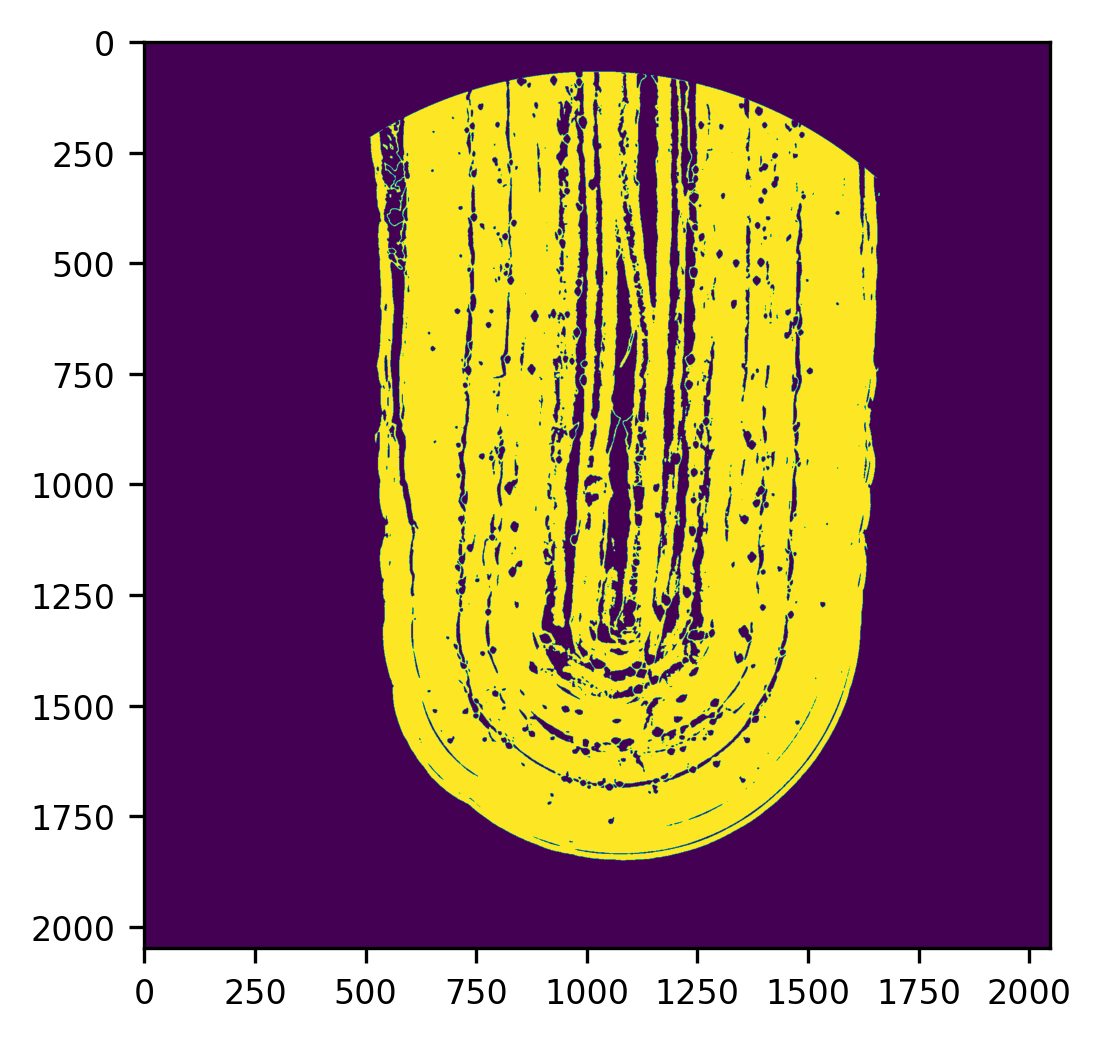

In [181]:
plt.imshow(BW_pit[0,:,:])

2.1.5. Close open surface of the pit with the cirle mask

In [48]:
# BW_pit2 = BW_pit & morphology.binary_dilation(BW_circle, morphology.cube(5))

In [98]:
# BW_pit2 = ndimage.binary_closing(~(BW_pit | BW_circle), morphology.cube(3), iterations=3 border_value=1)

2.1.6. Find holes within pit

In [190]:
BW_holes_within_pit = remove_largest(~(BW_pit | BW_circle))

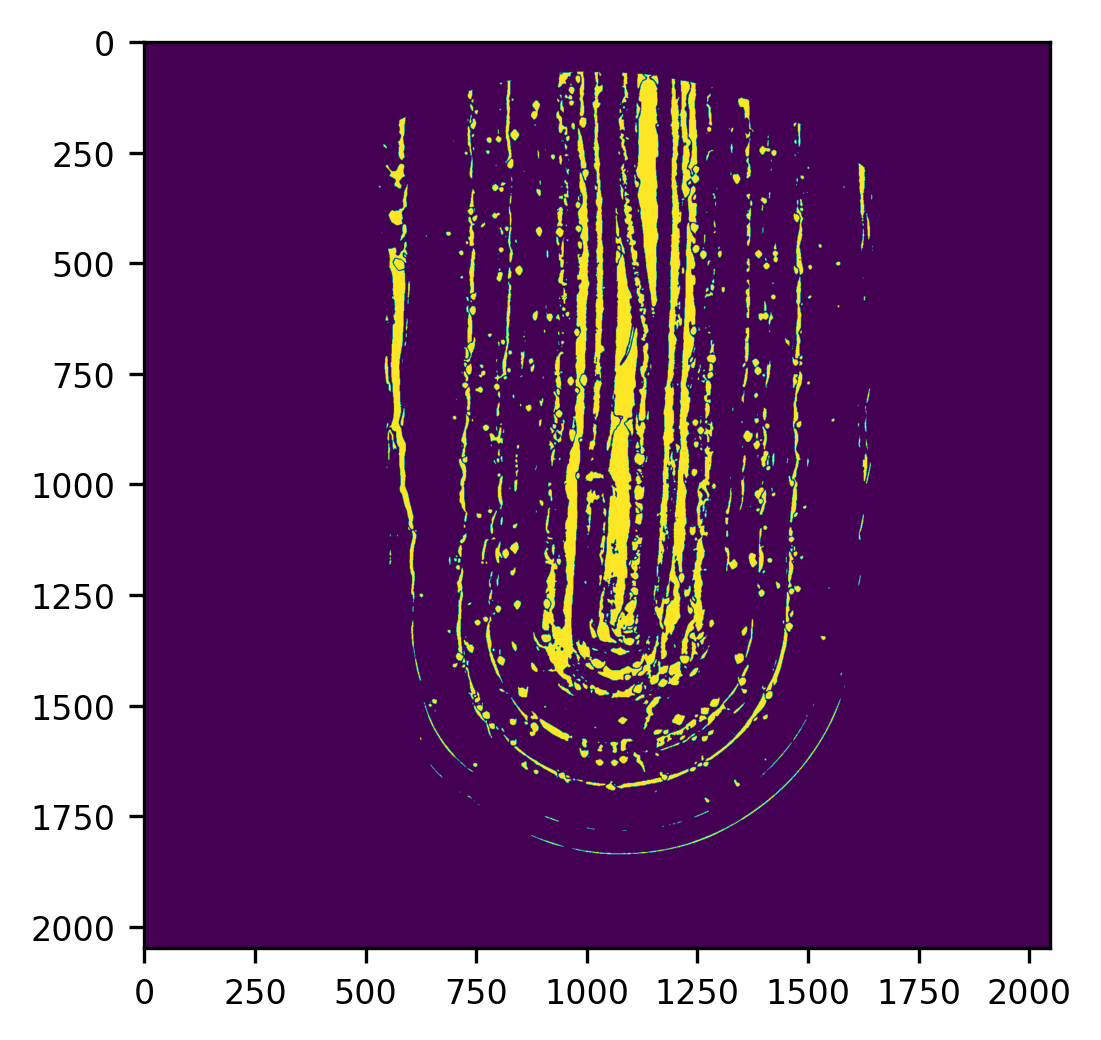

In [191]:
plt.imshow(BW_holes_within_pit[10,:,:])

2.1.7. Pit mask (holes removed)

In [192]:
BW_pit = BW_pit | BW_holes_within_pit

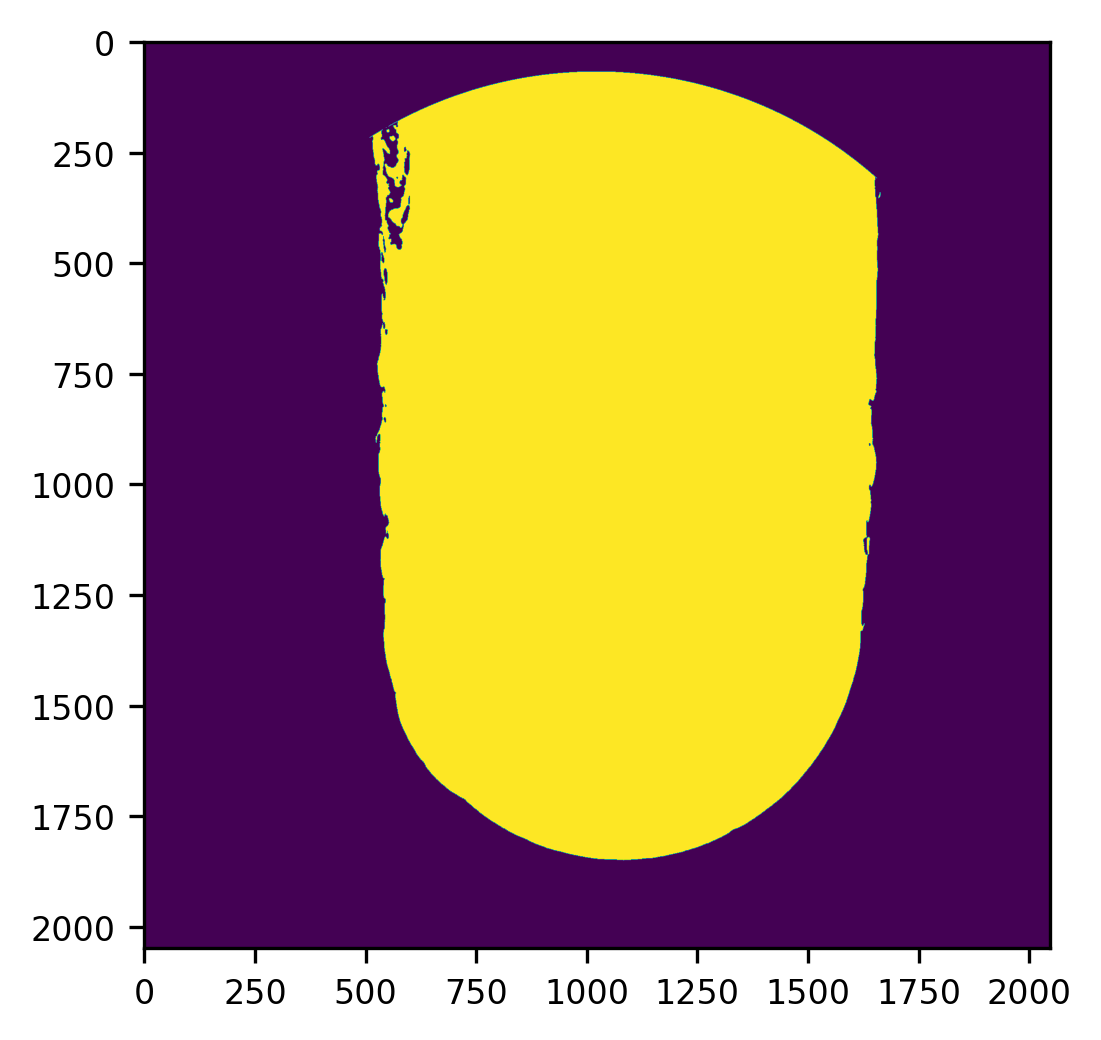

In [194]:
plt.imshow(BW_pit[20,:,:])

In [113]:
BW_pit2 = ndimage.binary_dilation(BW_pit | BW_circle, morphology.cube(3), iterations=2)

In [125]:
import porespy as ps

In [159]:
func = ndimage.binary_fill_holes

In [160]:
BW_pit2 = ndimage.binary_closing(BW_pit | BW_circle, morphology.cube(3), iterations=1, border_value=1)

In [156]:
BW_pit2 = ps.filters.apply_padded(im=~BW_pit2, pad_width=1, func=func, pad_val=1)

In [122]:
BW_pit2 = ndimage.binary_fill_holes(ndimage.binary_dilation(BW_pit | BW_circle, morphology.cube(3), iterations=5))

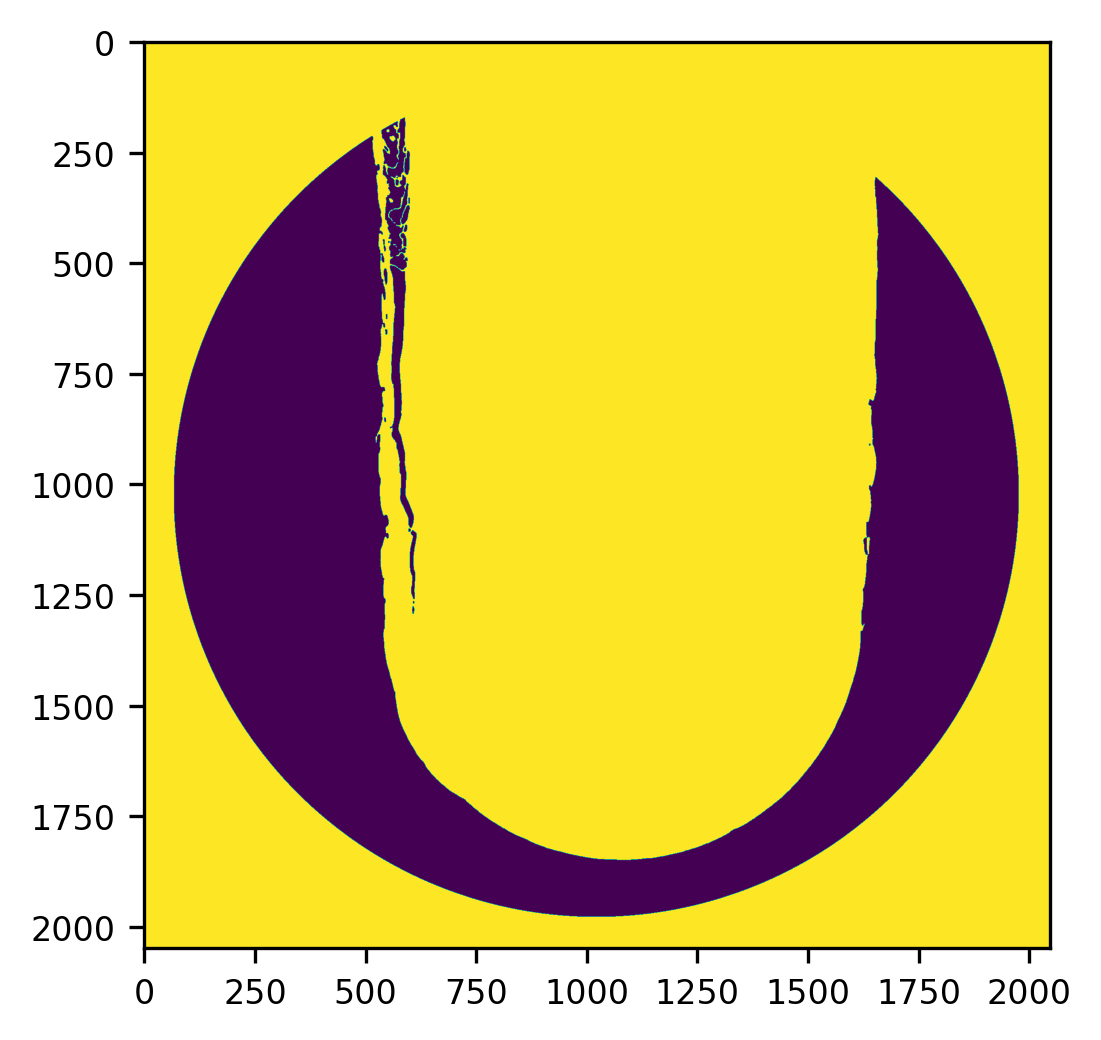

In [163]:
plt.imshow(BW_pit2[20,:,:])

In [ ]:
binary_closing(BW_pit[20,:,:] | BW_holes_within_pit[20,:,:], morphology.square(20))

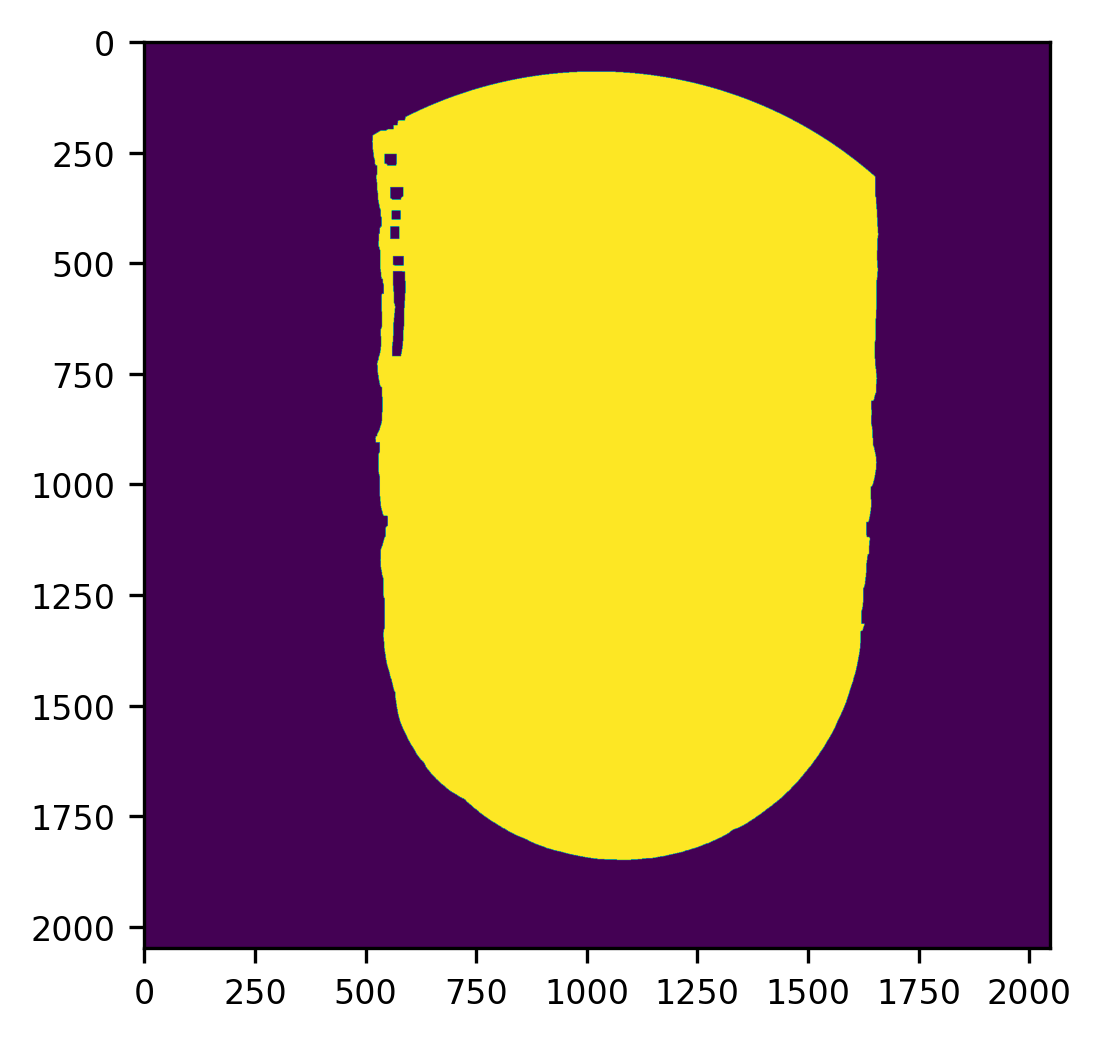

In [24]:
plt.imshow(binary_closing(BW_pit[20,:,:] | BW_holes_within_pit[20,:,:], morphology.square(20)))

In [23]:
BW_holes_within_pit = ~(BW_pit | BW_circle)

In [66]:
import dxchange

In [124]:
dxchange.write_tiff_stack(BW_pit2, "/media/gianthk/My Passport/20217193_Traviglia/recons/masks/581681_punta_HR_stitch2_merge_corr_phrt/pippo/slice.tiff")

In [14]:
BW_pit = ndimage.binary_fill_holes(BW)

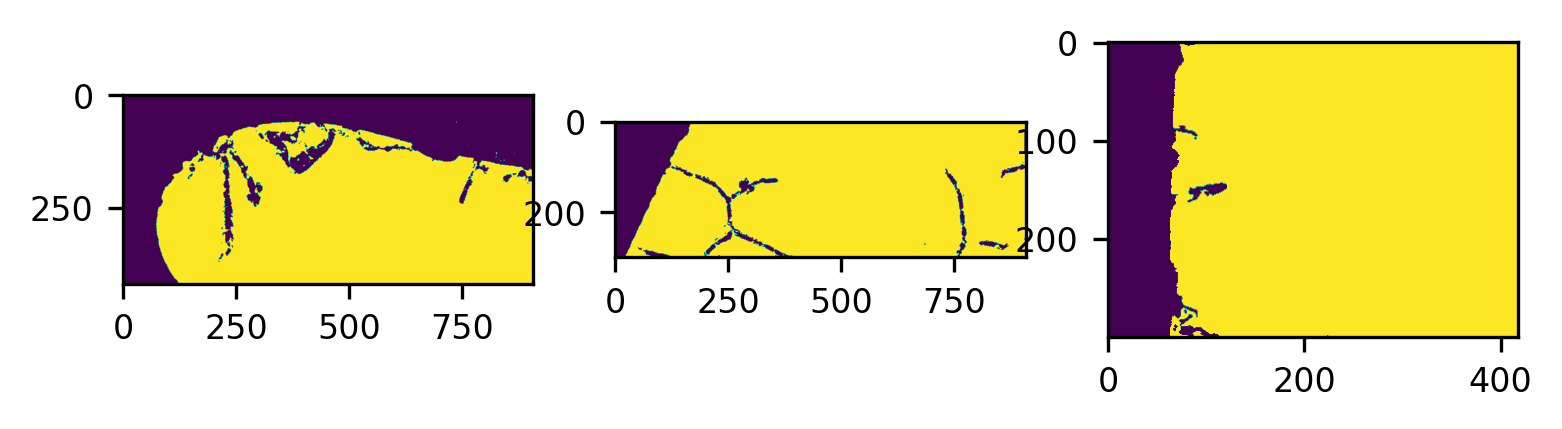

In [15]:
# Inspect dataset
plot_midplanes(BWfill)
plt.show()

### 2.2. remove unconnected objects

In [16]:
from pybonemorph import remove_unconnected 

In [18]:
BWfill = remove_unconnected(BWfill)

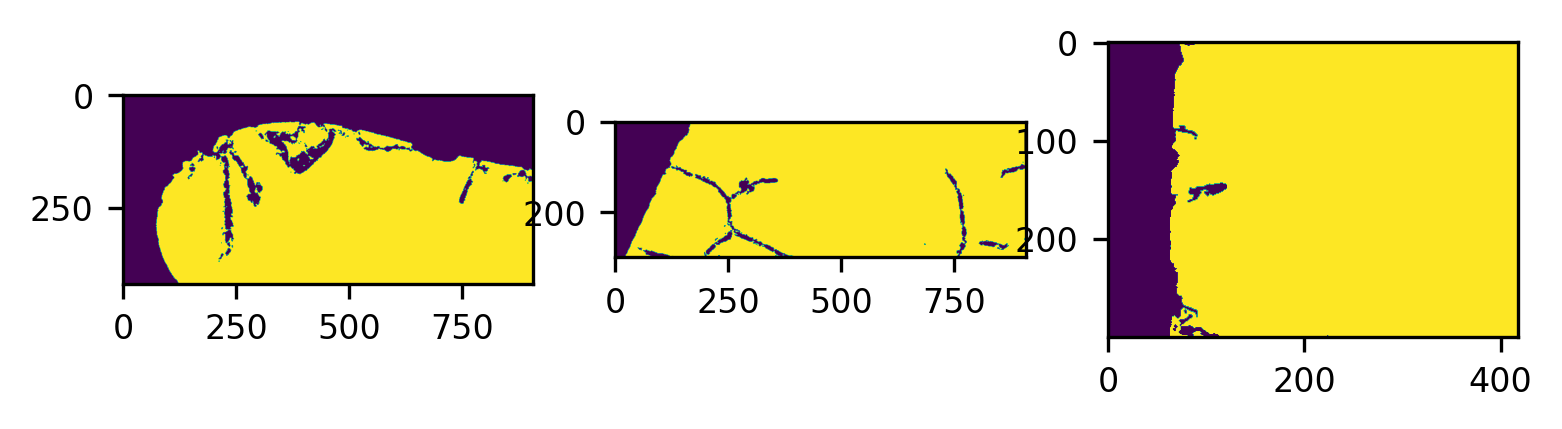

In [19]:
# Inspect dataset
plot_midplanes(BWfill)
plt.show()

### 2.3. Image close to fill the cracks

In [44]:
BW_close = morphology.closing(BWfill, morphology.cube(20))

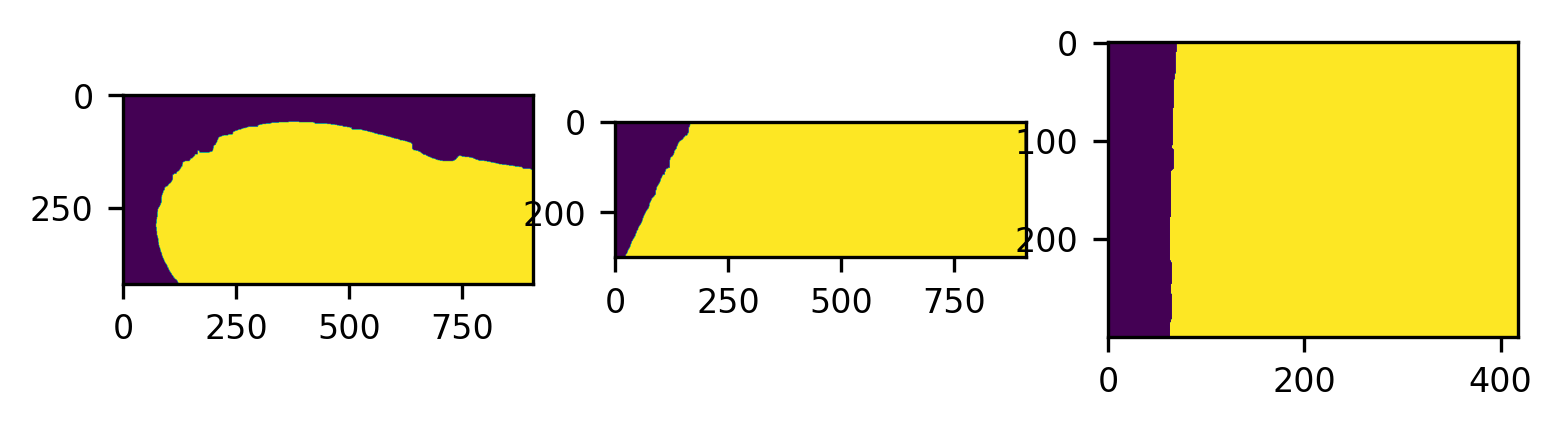

In [46]:
# Inspect dataset
plot_midplanes(BW_close)
plt.show()

Inspect with [napari](https://napari.org/)

In [ ]:
import napari
viewer = napari.view_image(BW_close)

### 2.4. outer sample boundary

In [48]:
BW_boudary = BW_close & ~morphology.erosion(BW_close)

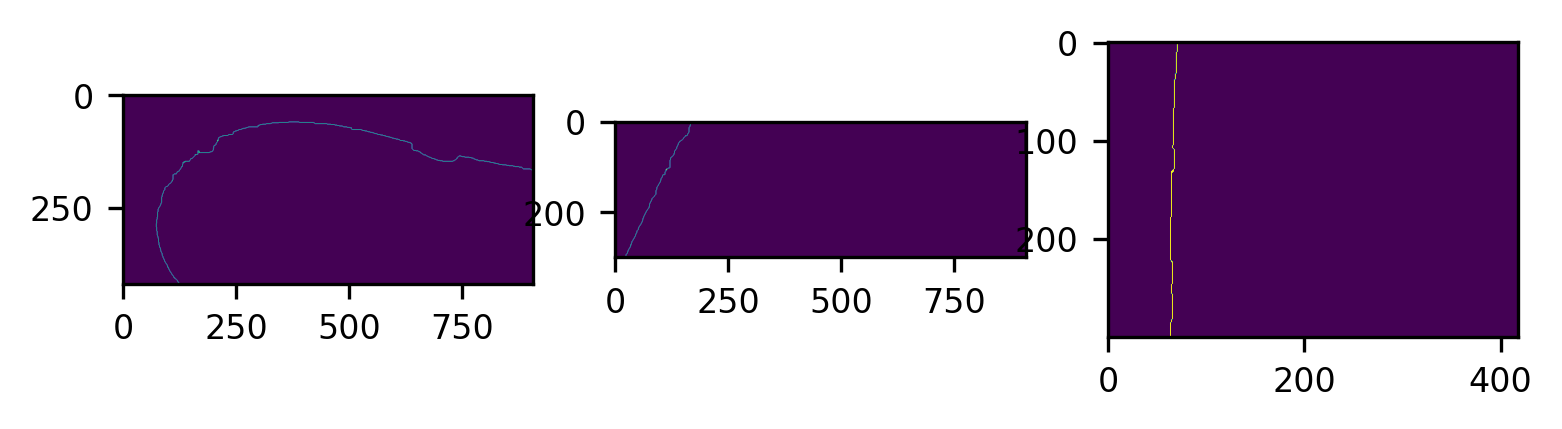

In [47]:
# Inspect dataset
plot_midplanes(BW_boudary)
plt.show()

## 3. analyzing cracks depth
### 3.1. distance transform from sample surface

In [51]:
dist = ndimage.distance_transform_edt(~BW_boudary)

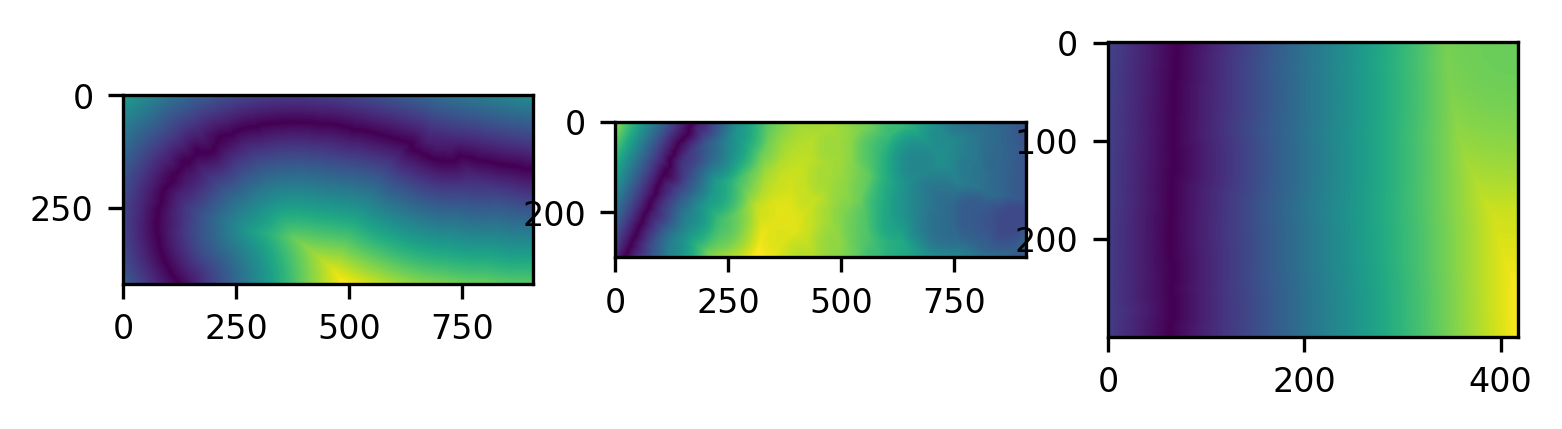

In [52]:
plot_midplanes(dist)
plt.show()

### 3.2. binary mask of the cracks

In [53]:
BW_cracks = BW_close & ~BW

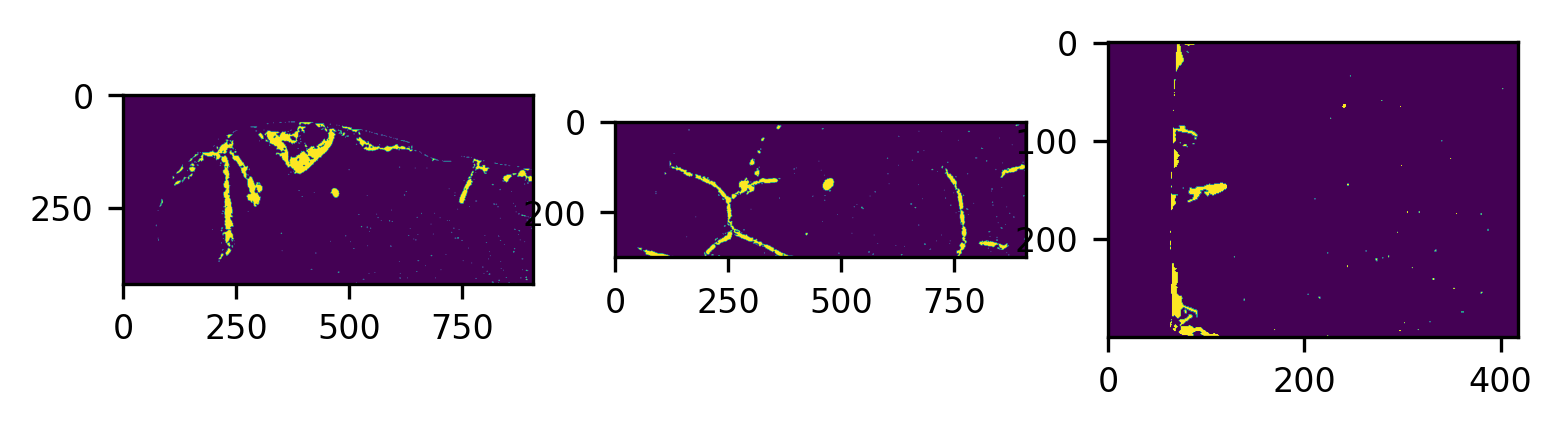

In [54]:
plot_midplanes(BW_cracks)
plt.show()

### 3.3. crack depth distribution

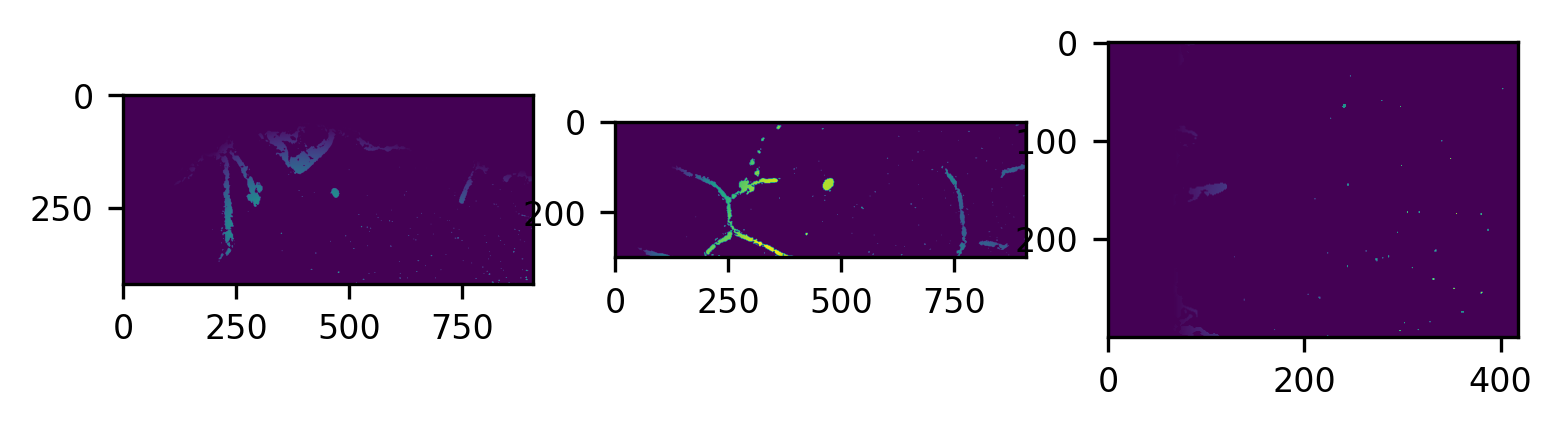

In [56]:
plot_midplanes(dist * BW_cracks)
plt.show()

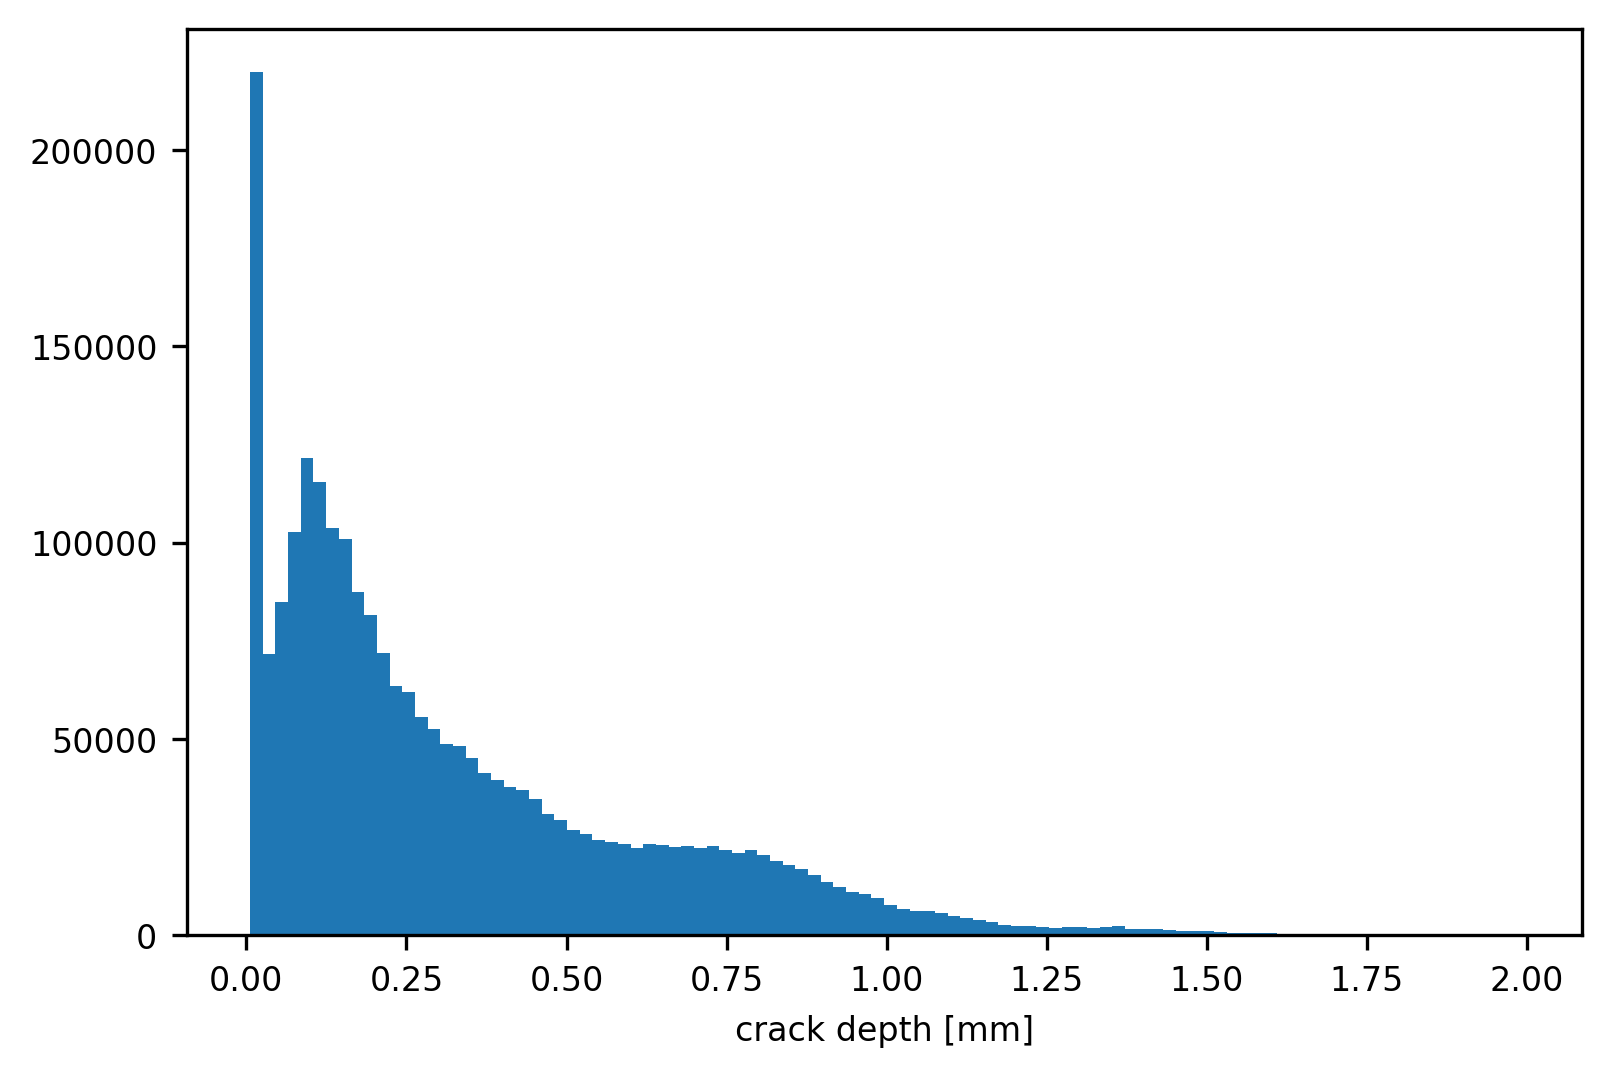

In [64]:
crack_dist = (dist * BW_cracks).ravel() * vs[0]
crack_dist[crack_dist == 0] = np.nan

fig2, ax2 = plt.subplots()
plt.hist(crack_dist, bins=100)
plt.xlabel('crack depth [mm]')
plt.show()